In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import preprocessor as p
import re

pd.set_option('display.max_colwidth', None)
tqdm.pandas()


In [3]:
all_files = []
for dirname, _, filenames in os.walk('/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/war_data/data/'):
    for filename in filenames:
        full_path=os.path.join(dirname, filename)
        all_files.append(full_path)

In [4]:
tmp_df_list = []
for file in all_files:
    print(f"Reading in {file}")
    tmp_df = pd.read_csv(file)
    print(f"\t{len(tmp_df)} entries")
    tmp_df_list.append(tmp_df)

print("Concatenating the DataFrames")
data = pd.concat(tmp_df_list, axis=0)
print("Concatenation complete!")

Reading in /vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/war_data/data/Russian_border_Ukraine.csv
	53040 entries
Reading in /vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/war_data/data/Ukraine_nato.csv
	245232 entries
Reading in /vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/war_data/data/Russia_invade.csv
	170835 entries
Reading in /vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/war_data/data/StandWithUkraine.csv
	148145 entries
Reading in /vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/war_data/data/Ukraine_troops.csv
	172714 entries
Reading in /vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/war_data/data/Russian_troops.csv
	128405 entries
Reading in /vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/war_data/data/Ukraine_war.csv
	231624 entries
Reading in /vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/war_da

In [5]:
# data = pd.read_csv('/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/war_data/Russian_border_Ukraine.csv')
print(data.info(max_cols=29))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1316605 entries, 0 to 166609
Data columns (total 29 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   _type             1316605 non-null  object 
 1   url               1316605 non-null  object 
 2   date              1316605 non-null  object 
 3   content           1316605 non-null  object 
 4   renderedContent   1316605 non-null  object 
 5   id                1316605 non-null  int64  
 6   user              1316605 non-null  object 
 7   replyCount        1316605 non-null  int64  
 8   retweetCount      1316605 non-null  int64  
 9   likeCount         1316605 non-null  int64  
 10  quoteCount        1316605 non-null  int64  
 11  conversationId    1316605 non-null  int64  
 12  lang              1316605 non-null  object 
 13  source            1316605 non-null  object 
 14  sourceUrl         1316605 non-null  object 
 15  sourceLabel       1316605 non-null  object 
 16  o

In [6]:
data["date"] = pd.to_datetime(data["date"])

earliest_tweet = data["date"].min()
latest_tweet = data["date"].max()

print(f"The earliest tweet was at {earliest_tweet}, and the latest was at {latest_tweet}")

The earliest tweet was at 2021-12-31 00:00:30+00:00, and the latest was at 2022-03-05 23:59:59+00:00


In [7]:
print(f"There are {data['lang'].nunique()} unique languages in this DataFrame.")
print(data["lang"].unique())
print(f"{round(data.loc[data['lang']=='en'].shape[0]/data.shape[0]*100, 2)}% of the tweets are in English.")

There are 61 unique languages in this DataFrame.
['en' 'es' 'und' 'hi' 'in' 'de' 'ja' 'pl' 'et' 'zh' 'ro' 'nl' 'tr' 'pa'
 'da' 'pt' 'tl' 'eu' 'fr' 'no' 'cs' 'ru' 'fi' 'it' 'sv' 'ca' 'kn' 'sl'
 'ta' 'ar' 'ko' 'ur' 'bn' 'gu' 'sr' 'th' 'lt' 'uk' 'el' 'cy' 'vi' 'lv'
 'hu' 'ht' 'km' 'fa' 'ml' 'am' 'ne' 'my' 'mr' 'te' 'or' 'ps' 'ka' 'iw'
 'bg' 'dv' 'is' 'sd' 'si']
91.67% of the tweets are in English.


In [8]:
prev_size = len(data)
# drop rows with missing values in the 'renderedContent' column
data = data.dropna(subset=['renderedContent'])
# drop all rows with non english text
data = data[data['lang'] == 'en'].drop(columns=['lang'])
change = prev_size - len(data)
print(f"Dropped {change} rows")

Dropped 109620 rows


In [9]:
count = data['renderedContent'].progress_apply(lambda x: x.count('#Ukraine')).sum()
print(f"#Ukraine appears {count} times")


100%|██████████| 1206985/1206985 [00:01<00:00, 784112.20it/s]

#Ukraine appears 157391 times


In [10]:
# Define a regular expression pattern to match hashtags
pattern = r'#(\w+)'

# Extract hashtags from the renderedContent column and concatenate them into a single list
hashtags = []
for text in data['renderedContent']:
    # print(text)
    # print(re.findall(pattern, text))
    hashtags += re.findall(pattern, text)

# Count the frequency of each hashtag
hashtag_counts = pd.Series(hashtags).value_counts()

# Print the top 10 most common hashtags
print("Ten most common hashtags in the text:")
print(hashtag_counts.head(25))

most_common_hashtag = hashtag_counts.iloc[:25]

Ten most common hashtags in the text:
Ukraine                114895
StandWithUkraine        63357
Russia                  55317
NATO                    29862
Putin                   17162
Russian                 13652
ukraine                  8142
UkraineCrisis            6911
US                       6014
USA                      5772
RussiaUkraine            5289
Biden                    5195
UkraineRussiaWar         5146
UkraineWar               5123
russia                   4843
UkraineConflict          4756
Europe                   4568
Belarus                  4551
war                      4264
UkraineInvasion          4026
BREAKING                 3928
Kyiv                     3853
EU                       3627
RussiaUkraineCrisis      3537
news                     3188
dtype: int64


In [14]:
# Define a regular expression pattern to match hashtags
pattern = r'@(\w+)'

# Extract hashtags from the renderedContent column and concatenate them into a single list
mentions = []
for text in data['renderedContent']:
    # print(text)
    # print(re.findall(pattern, text))
    mentions += re.findall(pattern, text)

# Count the frequency of each mention
mention_counts = pd.Series(mentions).value_counts()

# Print the top 10 most common mentions
print("Ten most common mentions in the text:")
print(mention_counts.head(10))
most_common_mentions = mention_counts.iloc[:10]

Ten most common mentions in the text:
NATO               22099
POTUS              20818
YouTube             8637
KremlinRussia_E     7808
ZelenskyyUa         7545
McFaul              7282
Reuters             7027
SecBlinken          6604
mfa_russia          6452
Ukraine             6260
dtype: int64


In [15]:
def remove_unnecessary(text):
    for hashtag in most_common_hashtag.keys():
        text = text.replace(f"#{hashtag}", " ".join(re.findall('[A-Z][^A-Z]*', hashtag)))
    for mention in most_common_mentions.keys():
        text = text.replace(f'@{mention}', mention)
    p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.NUMBER, p.OPT.EMOJI, p.OPT.SMILEY)
    result = p.clean(text)
    return result

data["cleanedTweet"] = data["renderedContent"].progress_map(remove_unnecessary)

100%|██████████| 1206985/1206985 [03:39<00:00, 5493.85it/s]


In [16]:
data[['renderedContent', 'cleanedTweet']].head()

,renderedContent,cleanedTweet
0,"Is that the same expensive and ineffective border wall that smugglers have breached over 3000 times in the past couple years? And yet the gasbag, azzhat Rosedale withholds aid to Ukraine. Russian enabler. twitter.com/ronfilipkowski…","Is that the same expensive and ineffective border wall that smugglers have breached over times in the past couple years? And yet the gasbag, azzhat Rosedale withholds aid to Ukraine. Russian enabler."
1,"@DonWaifu @gabehayes @aaronjmate So the Americans are dressing up as Russians, crossing the russian border and launching Russian bombs out of Russian equipment? The us is not in Ukraine at all.","So the Americans are dressing up as Russians, crossing the russian border and launching Russian bombs out of Russian equipment? The us is not in Ukraine at all."
2,Maybe if one military unit from Ukraine crossed the border and inialaited a Russian city then Putin might stop,Maybe if one military unit from Ukraine crossed the border and inialaited a Russian city then Putin might stop
3,Volunteers cross Polish border into Ukraine to fight Russian forces news.yahoo.com/volunteers-cro…,Volunteers cross Polish border into Ukraine to fight Russian forces
4,@MarkHertling BUT... theres no Russian aircraft flying near Lviv. Why not carve out a 'safe zone' on the ground from Lviv to Poland border and setup refugee camps *inside* Ukraine and defend it? Warn Russia that we will fight if they bomb here. Will help the humanitarian situation?,BUT... theres no Russian aircraft flying near Lviv. Why not carve out a 'safe zone' on the ground from Lviv to Poland border and setup refugee camps *inside* Ukraine and defend it? Warn Russia that we will fight if they bomb here. Will help the humanitarian situation?


In [17]:
# Define a function to perform sentiment analysis on a text using TextBlob
analyser = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return analyser.polarity_scores(text)

def unpack_sentiment_scores(scores):
    return pd.Series([scores['neg'], scores['neu'], scores['pos'], scores['compound']])

# Apply sentiment analysis to the filtered tweets and unpack the scores into separate columns
data[['neg_score', 'neu_score', 'pos_score', 'compound_score']] = data['cleanedTweet'].progress_apply(get_sentiment).progress_apply(unpack_sentiment_scores)

# Print the average sentiment score of the filtered tweets
print("Average sentiment score of tweets:", data['compound_score'].mean())

# Before: Average sentiment score of tweets: -0.1677131671064678

100%|██████████| 1206985/1206985 [03:23<00:00, 5933.23it/s] 


Average sentiment score of tweets: -0.17187063244365092


In [18]:
data.head()

,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,...,coordinates,place,hashtags,cashtags,Searh,cleanedTweet,neg_score,neu_score,pos_score,compound_score
0,snscrape.modules.twitter.Tweet,https://twitter.com/donveach/status/1500259722112520194,2022-03-05 23:59:25+00:00,"Is that the same expensive and ineffective border wall that smugglers have breached over 3000 times in the past couple years? And yet the gasbag, azzhat Rosedale withholds aid to Ukraine. Russian enabler. https://t.co/UwbGIPgiYd","Is that the same expensive and ineffective border wall that smugglers have breached over 3000 times in the past couple years? And yet the gasbag, azzhat Rosedale withholds aid to Ukraine. Russian enabler. twitter.com/ronfilipkowski…",1500259722112520194,"{'_type': 'snscrape.modules.twitter.User', 'username': 'donveach', 'id': 2864827297, 'displayname': 'Don Veach', 'description': 'Proud New Orleanian. Tulane grad. Vote out anyone who praises or supports the Russian invasion of Ukraine #BidenHarris', 'rawDescription': 'Proud New Orleanian. Tulane grad. Vote out anyone who praises or supports the Russian invasion of Ukraine #BidenHarris', 'descriptionUrls': None, 'verified': False, 'created': '2014-10-19T11:37:54+00:00', 'followersCount': 1972, 'friendsCount': 1967, 'statusesCount': 1776, 'favouritesCount': 1459, 'listedCount': 0, 'mediaCount': 127, 'location': 'New Orleans, LA', 'protected': False, 'linkUrl': None, 'linkTcourl': None, 'profileImageUrl': 'https://pbs.twimg.com/profile_images/1287190374671364098/TCSvJovW_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/2864827297/1613400061', 'label': None, 'url': 'https://twitter.com/donveach'}",0,0,1,...,NaN,NaN,NaN,NaN,Russian border Ukraine,"Is that the same expensive and ineffective border wall that smugglers have breached over times in the past couple years? And yet the gasbag, azzhat Rosedale withholds aid to Ukraine. Russian enabler.",0.115,0.885,0.000,-0.4404
1,snscrape.modules.twitter.Tweet,https://twitter.com/deliveryman199/status/1500259491232641025,2022-03-05 23:58:30+00:00,"@DonWaifu @gabehayes @aaronjmate So the Americans are dressing up as Russians, crossing the russian border and launching Russian bombs out of Russian equipment? The us is not in Ukraine at all.","@DonWaifu @gabehayes @aaronjmate So the Americans are dressing up as Russians, crossing the russian border and launching Russian bombs out of Russian equipment? The us is not in Ukraine at all.",1500259491232641025,"{'_type': 'snscrape.modules.twitter.User', 'username': 'deliveryman199', 'id': 1353394991997931520, 'displayname': 'eli leon', 'description': '', 'rawDescription': '', 'descriptionUrls': None, 'verified': False, 'created': '2021-01-24T17:31:43+00:00', 'followersCount': 1, 'friendsCount': 4, 'statusesCount': 232, 'favouritesCount': 75, 'listedCount': 0, 'mediaCount': 13, 'location': '', 'protected': False, 'linkUrl': None, 'linkTcourl': None, 'profileImageUrl': 'https://pbs.twimg.com/profile_images/1486892106828312579/7ZMZ1asL_normal.jpg', 'profileBannerUrl': None, 'label': None, 'url': 'https://twitter.com/deliveryman199'}",1,0,2,...,NaN,NaN,NaN,NaN,Russian border Ukraine,"So the Americans are dressing up as Russians, crossing the russian border and launching Russian bombs out of Russian equipment? The us is not in Ukraine at all.",0.000,1.000,0.000,0.0000
2,snscrape.modules.twitter.Tweet,https://twitter.com/JDiozzi/status/1500259115863777280,2022-03-05 23:57:01+00:00,Maybe if one military unit from Ukraine crossed the border and inialaited a Russian city then Putin might stop,Maybe if one military unit from Ukraine crossed the border and inialaited a Russian city then Putin might stop,1500259115863777280,"{'_type': 'snscrape.modules.twitter.User', 'username': 'JDiozzi', 'id': 1434999581159403522, 'displayname': 'Joseph Diozzi', 'description': '', 'rawDescription': '', 'descriptionUrls': None, 'verified': False, 'created': '2021-09-06T21:59:56+00:

In [22]:
reduced_data = data[['id', 'renderedContent', 'cleanedTweet', 'neg_score', 'neu_score', 'pos_score', 'compound_score']]
reduced_data.to_csv("analysed_data.csv")

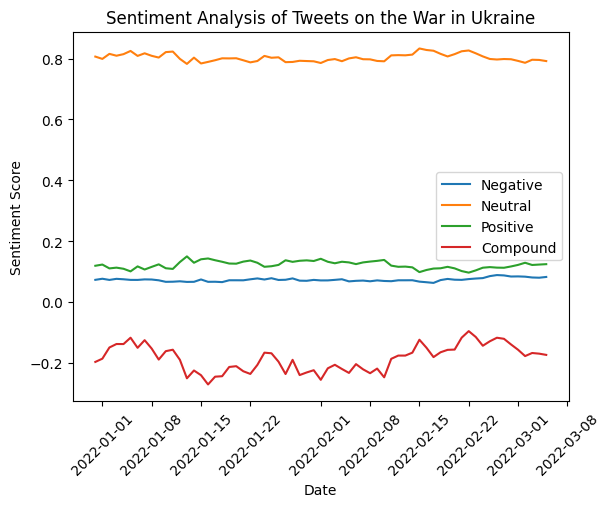

In [20]:
neg_sentiment = data.groupby(pd.to_datetime(data['date']).dt.date)['pos_score'].mean()
neu_sentiment = data.groupby(pd.to_datetime(data['date']).dt.date)['neu_score'].mean()
pos_sentiment = data.groupby(pd.to_datetime(data['date']).dt.date)['neg_score'].mean()
compound_sentiment = data.groupby(pd.to_datetime(data['date']).dt.date)['compound_score'].mean()

plt.plot(neg_sentiment.index, neg_sentiment.values, label='Negative')
plt.plot(neu_sentiment.index, neu_sentiment.values, label='Neutral')
plt.plot(pos_sentiment.index, pos_sentiment.values, label='Positive')
plt.plot(compound_sentiment.index, compound_sentiment.values, label='Compound')

plt.title('Sentiment Analysis of Tweets on the War in Ukraine')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()

# Rotate x-tick labels by 45 degrees
plt.xticks(rotation=45)

plt.show()

In [23]:
reduced_data.head()

,id,renderedContent,cleanedTweet,neg_score,neu_score,pos_score,compound_score
0,1500259722112520194,"Is that the same expensive and ineffective border wall that smugglers have breached over 3000 times in the past couple years? And yet the gasbag, azzhat Rosedale withholds aid to Ukraine. Russian enabler. twitter.com/ronfilipkowski…","Is that the same expensive and ineffective border wall that smugglers have breached over times in the past couple years? And yet the gasbag, azzhat Rosedale withholds aid to Ukraine. Russian enabler.",0.115,0.885,0.000,-0.4404
1,1500259491232641025,"@DonWaifu @gabehayes @aaronjmate So the Americans are dressing up as Russians, crossing the russian border and launching Russian bombs out of Russian equipment? The us is not in Ukraine at all.","So the Americans are dressing up as Russians, crossing the russian border and launching Russian bombs out of Russian equipment? The us is not in Ukraine at all.",0.000,1.000,0.000,0.0000
2,1500259115863777280,Maybe if one military unit from Ukraine crossed the border and inialaited a Russian city then Putin might stop,Maybe if one military unit from Ukraine crossed the border and inialaited a Russian city then Putin might stop,0.109,0.891,0.000,-0.2960
3,1500258740423086083,Volunteers cross Polish border into Ukraine to fight Russian forces news.yahoo.com/volunteers-cro…,Volunteers cross Polish border into Ukraine to fight Russian forces,0.224,0.776,0.000,-0.3818
4,1500258434414874625,@MarkHertling BUT... theres no Russian aircraft flying near Lviv. Why not carve out a 'safe zone' on the ground from Lviv to Poland border and setup refugee camps *inside* Ukraine and defend it? Warn Russia that we will fight if they bomb here. Will help the humanitarian situation?,BUT... theres no Russian aircraft flying near Lviv. Why not carve out a 'safe zone' on the ground from Lviv to Poland border and setup refugee camps *inside* Ukraine and defend it? Warn Russia that we will fight if they bomb here. Will help the humanitarian situation?,0.205,0.674,0.122,-0.6199


In [27]:
positive = (reduced_data['compound_score'] > 0.05).sum()
negaive = (reduced_data['compound_score'] < -0.05).sum()
neutral = ((reduced_data['compound_score'] >= -0.05) & (reduced_data['compound_score'] <= 0.05)).sum()
extreme_negative = (reduced_data['compound_score'] < -0.2).sum()
print(f"Positive tweets: {positive}\nNeutral tweets: {neutral}\nNegative tweets: {negaive}\nExtreme Negative: {extreme_negative}")

Positive tweets: 355076
Neutral tweets: 200770
Negative tweets: 651139
Extreme Negative: 594127


In [30]:
smallest_scores = reduced_data.nsmallest(10, 'compound_score')
for index, row in smallest_scores.iterrows():
    print(f"{row['cleanedTweet']}\tscore: {row['compound_score']}")

SHAME! SHAME! SHAME! SHAME! SHAME! SHAME! SHAME! SHAME! SHAME! SHAME! SHAME! SHAME! SHAME! SHAME! SHAME! SHAME! SHAME! SHAME! SHAME! SHAME! Stand With Ukraine	score: -0.9978
mfa_russia PUTIN IS A WAR CRIMINAL PUTIN IS A WAR CRIMINAL PUTIN IS A WAR CRIMINAL PUTIN IS A WAR CRIMINAL PUTIN IS A WAR CRIMINAL PUTIN IS A WAR CRIMINAL PUTIN IS A WAR CRIMINAL PUTIN IS A WAR CRIMINAL PutinIsAWarCriminal PutinWarCriminal Stand With Ukraine	score: -0.9974
WAR WAR WAR WAR WAR This is what your madman Putin has started in the Ukraine.He has killed hundreds of civilians including women &amp; children.He has killed thousands of his own troops.This is WAR WAR WAR WAR WAR The people of Russia and the military need to know the truth. WAR WAR	score: -0.9969
WAR WAR WAR WAR WAR This is what your madman Putin has started in the Ukraine.He has killed hundreds of civilians including women &amp; children.He has killed thousands of his own troops.This is WAR WAR WAR The people of Russia and the military need to

In [40]:
largest_scores = reduced_data.nlargest(10, 'compound_score')
for index, row in largest_scores.iterrows():
    print(f"{row['cleanedTweet']}\tscore: {row['compound_score']}")

RUSSIAN KING PUTIN. PLEASE SEE HOW WONDERFUL THE LANDS &amp; PEOPLE'S ENJOY LIFE FAMILIES LOVE OF BOTH RUSSIAN &amp; UKRAINE TOO. I HAVE WONDERFUL KNOWLEDGE TO ENGINE FREE CLEAN ENERGY. JOBS LONGEVITY PROSPERITY. FEEL BETTER PLEASE NO WAR. LOVE COMPASSION IQ225. I LOVE TO HELP ME.	score: 0.9942
he will not stop there. So, I do not envy you, but I hope you show the world we are exactly who we are, strong, brave, compassionate, and ready to defend. Please help Ukraine as much as possible, and God Bless You, Our Troops and Our Nation, and the rest of the free world.	score: 0.991
POTUS THANK- YOU PRESIDENT BIDEN FOR SUPPORTING UKRAINE!!! HOPEFULLY PUTIN WILL DO THE RIGHT THING TO KEEP PEACE!!! WE ALL NEED TO WORK TOGETHER TO PREVENT A WAR!!! GOD BLESS YOU!!! GOD BLESS AMERICA!!! &amp; GOD BLESS THIS WORLD!!! PEACE ON EARTH GOOD WILL TOWARDS MEN!!!	score: 0.9905
Good night, friends. Subscribe of my Twitter. I have followers. I love for you . Best wishes, Oksana. Glory to Ukraine. I went, wh

In [38]:
matches = reduced_data[(reduced_data['compound_score'] > 0.5) & (reduced_data['cleanedTweet'].str.contains("POTUS"))]
print(f"{len(matches)} found")
for index, row in matches.iterrows():
    print(f"{row['cleanedTweet']}\tscore: {row['compound_score']}")

3531 found
POTUS These kids have been abandoned not only by their home countries, but also Ukraine. Please let us step in and Rescue them- they are trapped in Sumy near the Russian border. At least they need water and food. Please help.	score: 0.8074
Very well said. Will POTUS accept KremlinRussia_E forces on Mexican US border? Expansion of NATO has threatened World peace much more than anything else. Ukraine must not have fallen in this trap	score: 0.6489
POTUS one of the best reasons to have a second amendment is on display right now in the Ukraine. If they had a second amendment they wouldnt have had to waste time trying to hand out rifles when Russian troops crossed the border.	score: 0.6808
POTUS It didn't have to be like this! Did Sleepy Joe think K Russian forces were having a winter'21 picnic at Ukraine border? This needed Massive influx of defensive arms in ! Why is still importing Putin's OIL?! Classic Joe: A day late and a dollar short!!	score: 0.6283
POTUS and give Ukraine 

In [39]:
matches = reduced_data[(reduced_data['compound_score'] < -0.5) & (reduced_data['cleanedTweet'].str.contains("POTUS"))]
print(f"{len(matches)} found")
for index, row in matches.iterrows():
    print(f"{row['cleanedTweet']}\tscore: {row['compound_score']}")

7842 found
If POTUS did visit the border you all would bitch that he isnt taking inflation or the Russian invasion of Ukraine seriously.	score: -0.6705
POTUS Impose OFFENSIVE capability to Ukraine. Allow them to target Russian infrastructure within miles of their border. Bridges, non- nuclear power stations, &amp; fuel supplies should be a priority.	score: -0.6166
POTUS Dear Mr.President, The Ukraine military needs hundreds of KAMIKAZE drones to aid in defending their country. The Russian column are dead ducks. Also a counter attack at the Russian border to hit rail lines will slow the logistics of supply,reinforcements &amp; ammunition delayed	score: -0.7717
POTUS Really? Your pissin $ for the Ukraine border, ours is wide open. You're killing US O&amp;G while building Russian O&amp;G. COL is of the charts. Not only the greatest security threat to real democracy, you are mentally unfit for office...total embarrassment to the office. Go away, pls!	score: -0.9129
POTUS I want you to focu

In [41]:
avg_score = reduced_data[reduced_data['cleanedTweet'].str.contains("POTUS")]['compound_score'].mean()
print(avg_score)

-0.16200267036267038


In [2]:
reduced_data = pd.read_csv('/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/war_data/analysed_data.csv')

/tmp/ipykernel_1308852/1858072296.py:1: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  reduced_data = pd.read_csv('/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/war_data/analysed_data.csv')


In [ ]:
reduced_data['cleanedTweet'].isna().any()

True

In [5]:
keywords = [
    "Russia",
    "Ukraine",
    "NATO",
    "Biden",
    "POTUS",
    "Borris Johnson",
    "War"
]
scores = {}
for word in tqdm(keywords):
    scores[word] = reduced_data[reduced_data['cleanedTweet'].str.contains(word)]['compound_score'].mean()

print(scores)

  0%|          | 0/7 [00:01<?, ?it/s]


ValueError: Cannot mask with non-boolean array containing NA / NaN values